# Wess Zumino 

## N=1 in 1+1

The Hamiltonian with a central difference for the derivative is given by 

In [1]:
import sympy as sp
from ham_to_sparse_matrix import *
from constants import *
import scipy.sparse.linalg

In [2]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

In [3]:
bosonNI+bosonI

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [11]:
fermionNI + fermionI

-0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a)

In [4]:
N=3
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

In [5]:
totHam=bosonNI+bosonI+fermionNI+fermionI
totHam

a*V(q_{n})**2/2 + q_{n+1}*V(q_{n})/4 - q_{n-1}*V(q_{n})/4 + V(q_{n})*q_{n+1}/4 - V(q_{n})*q_{n-1}/4 - 0.5*Derivative(V(q_{n}), q_{n}) + Derivative(V(q_{n}), q_{n})*\chi^{\dagger}_{n}*\chi_{n} - \chi^{\dagger}_{n+1}*\chi_{n}/(2*a) - \chi^{\dagger}_{n}*\chi_{n+1}/(2*a) + p_{n}**2/(2*a) - q_{n+1}*q_{n-1}/(8*a) + q_{n+1}**2/(8*a) - q_{n-1}*q_{n+1}/(8*a) + q_{n-1}**2/(8*a)

In [6]:
ham=0

mass=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    # m*q with m=1
    return mass*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

0.5 - \chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + \chi^{\dagger}_{1}*\chi_{1} - \chi^{\dagger}_{1}*\chi_{2}/2 - \chi^{\dagger}_{2}*\chi_{1}/2 - \chi^{\dagger}_{2}*\chi_{2} + p_{0}**2/2 + p_{1}**2/2 + p_{2}**2/2 - q_{0}*q_{2}/8 + 5*q_{0}**2/8 + 3*q_{1}**2/4 - q_{2}*q_{0}/8 + 5*q_{2}**2/8

In [7]:
m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

1/2 - \chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 + \chi^{\dagger}_{1}*\chi_{1} - \chi^{\dagger}_{1}*\chi_{2}/2 - \chi^{\dagger}_{2}*\chi_{1}/2 - \chi^{\dagger}_{2}*\chi_{2} - a^{\dagger}_{0}*a^{\dagger}_{2}/16 + 9*a^{\dagger}_{0}*a_{0}/16 - a^{\dagger}_{0}*a_{2}/16 + a^{\dagger}_{0}**2/16 + 5*a^{\dagger}_{1}*a_{1}/8 + a^{\dagger}_{1}**2/8 - a^{\dagger}_{2}*a^{\dagger}_{0}/16 - a^{\dagger}_{2}*a_{0}/16 + 9*a^{\dagger}_{2}*a_{2}/16 + a^{\dagger}_{2}**2/16 + 9*a_{0}*a^{\dagger}_{0}/16 - a_{0}*a^{\dagger}_{2}/16 - a_{0}*a_{2}/16 + a_{0}**2/16 + 5*a_{1}*a^{\dagger}_{1}/8 + a_{1}**2/8 - a_{2}*a^{\dagger}_{0}/16 + 9*a_{2}*a^{\dagger}_{2}/16 - a_{2}*a_{0}/16 + a_{2}**2/16

In [17]:
cutoff=6
hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)

/home/chris/anaconda3/envs/QuantumComputing/lib/python3.9/site-packages/scipy/sparse/_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


In [18]:
hamMat

<1728x1728 sparse matrix of type '<class 'numpy.complex64'>'
	with 25632 stored elements in Compressed Sparse Row format>

In [19]:
ens=scipy.sparse.linalg.eigs(hamMat,k=10,sigma=0)[0]

In [20]:
ens

array([0.13672549+3.9363273e-09j, 0.82286537-5.7748132e-08j,
       1.1349455 +7.4264133e-09j, 1.3228645 +6.9571717e-09j,
       1.4574281 +3.6721159e-09j, 1.5420889 +2.3216097e-08j,
       1.4574282 +4.9628056e-08j, 1.8210869 -1.0007612e-08j,
       1.8228647 -1.6949008e-08j, 2.137434  -8.2583407e-10j],
      dtype=complex64)

In [12]:
e0raw=[]

for cutoff in [2,3,4,5,6,7,8,9,10,11,12]:
    t=Timer('toHam')
    t.start()
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    t.stop()
    
    t=Timer('evals')
    t.start()
    ens=scipy.sparse.linalg.eigs(hamMat,k=10,sigma=0)[0]
    e0raw.append(ens[0])
    t.stop()
    
    print("Lambda = ",cutoff)
    print(ens)
    print()

toHam timer took: 0.3186 seconds
evals timer took: 0.0019 seconds
Lambda =  2
[-0.09974489-8.1066465e-10j  0.15025519-8.1583340e-10j
 -0.09974482-2.3763711e-09j  0.15025502-8.2368812e-10j
 -0.09974478+5.0066457e-10j  0.15025514-1.8434078e-09j
 -0.09974491+1.2575089e-09j  0.15025511+5.5199972e-10j
  0.9002541 +1.2396897e-08j  0.90025526-9.6734505e-09j]

toHam timer took: 0.6584 seconds
evals timer took: 0.0093 seconds
Lambda =  3
[-0.05103881-1.8186801e-09j  0.512777  +5.3556479e-09j
  0.5412189 +4.3037116e-09j  0.66703045-1.3411054e-08j
  0.94896084+5.7305076e-09j  0.9615351 +3.1636723e-08j
  1.0594175 +2.5267230e-08j  1.1383299 -1.9936913e-08j
  1.173705  -2.2046860e-09j  1.1737043 -3.1083747e-09j]

toHam timer took: 1.1568 seconds
evals timer took: 0.0122 seconds
Lambda =  4
[1.17475014e-04+4.50193788e-12j 9.07815576e-01-3.31917271e-09j
 9.56369102e-01+4.70403660e-10j 1.00011837e+00+2.10788738e-08j
 1.03278327e+00-8.94949803e-09j 1.21190763e+00-1.13813865e-08j
 1.31557000e+00+1.84047

In [1]:
e0raw=[(-0.099744886-8.1066465e-10j),
 (-0.05103881-1.8186801e-09j),
 (0.000117475014+4.501938e-12j),
 (-0.00035618097+1.3026091e-10j),
 (2.0708771e-06-3.3356182e-13j),
 (-3.5075593e-06+2.5672265e-13j),
 (2.5673984e-08-1.0334176e-15j),
 (-4.210903e-08-2.0428754e-14j),
 (3.1560718e-09-8.094191e-17j),
 (-5.974101e-09+2.8369815e-16j),
 (-9.765936e-09-4.759307e-15j)]

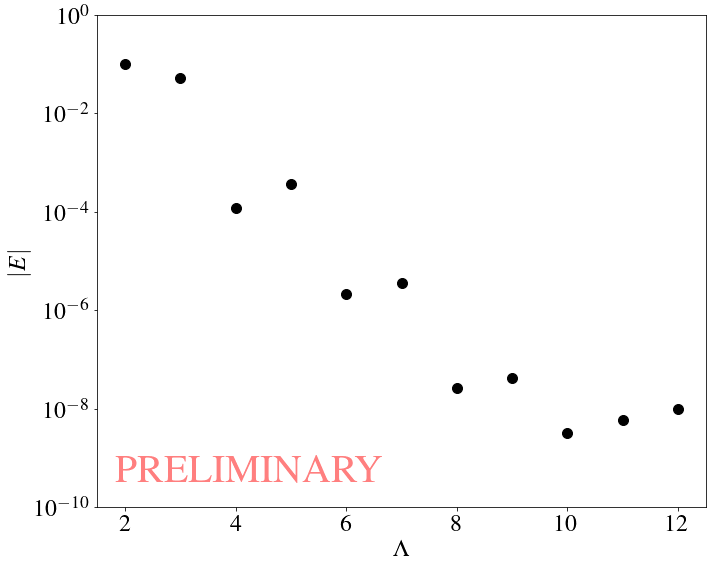

In [7]:
import matplotlib.pyplot as plt

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,13)],[abs(en.real) for en in e0raw], c='black')
plt.yscale('log')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,12.5)
plt.ylim(1e-10,1e0)
plt.yscale('log')

ax.text(0.25, 0.07, 'PRELIMINARY', transform=ax.transAxes,
        fontsize=40, color='red', alpha=0.5,
        ha='center', va='center', rotation='0')

plt.savefig('PLOTS/WZ_3site_vq1.pdf',bbox_inches='tight')